# Phân nhóm khách hàng trong siêu thị
Dữ liệu: tuổi, thu nhập, thói quen mua sắm.
K-means chia khách hàng thành các cụm: sinh viên thu nhập thấp, người đi làm thu nhập trung bình, người giàu hay mua hàng xa xỉ.
Giúp siêu thị xây dựng chương trình khuyến mãi phù hợp.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

# đổi đường dẫn tới đúng folder của bạn
os.chdir('/content/drive/MyDrive/Python_assignment/k_mean')

# kiểm tra xem có file không
print(os.getcwd())
!ls


/content/drive/MyDrive/Python_assignment/k_mean
k_means.ipynb  supermarket_customers_kmeans.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# K-Means là thuật toán phân cụm không giám sát. Thuật toán sẽ chia dữ liệu thành K nhóm bằng cách gán từng điểm vào tâm cụm gần nhất và cập nhật lại tâm cụm liên tục cho đến khi ổn định. Nó được dùng để phân nhóm dữ liệu có cấu trúc tương tự nhau.

## Huấn luyện K-means + chọn K (Elbow & Silhouette)

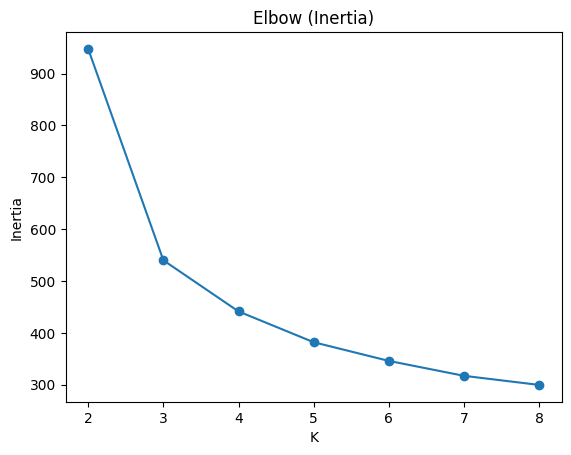

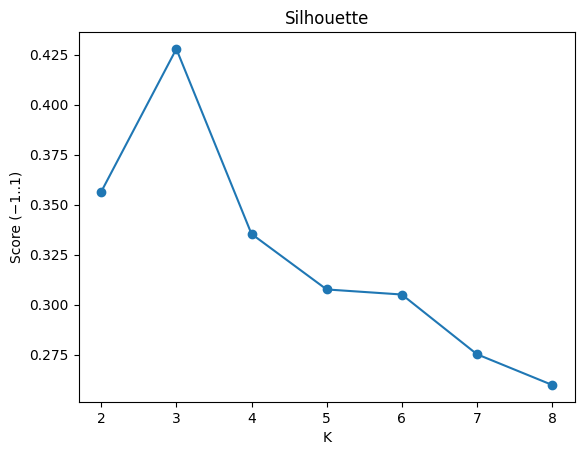

Cụm (trung bình đặc trưng):
      Age  Income_M_VND  VisitsPerMonth  LuxurySpendRatio  Cluster
0  21.94          7.64            9.67              0.11        0
1  37.31         20.90            5.12              0.24        1
2  37.09         60.42            3.01              0.65        2
Đã lưu: supermarket_customers_kmeans_labeled.csv


In [15]:
# 1) Đọc dữ liệu
df = pd.read_csv("supermarket_customers_kmeans.csv")
X = df[["Age", "Income_M_VND", "VisitsPerMonth", "LuxurySpendRatio"]].copy()

# 2) Chuẩn hóa (rất quan trọng cho K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) Chọn K bằng Elbow & Silhouette
inertias, sils, Ks = [], [], range(2, 9)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, km.labels_))

plt.figure()
plt.plot(list(Ks), inertias, marker="o")
plt.title("Elbow (Inertia)"); plt.xlabel("K"); plt.ylabel("Inertia"); plt.show()

plt.figure()
plt.plot(list(Ks), sils, marker="o")
plt.title("Silhouette"); plt.xlabel("K"); plt.ylabel("Score (−1..1)"); plt.show()

# 4) Chọn K (ví dụ: 4 cụm theo mô tả bài toán)
k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df["Cluster"] = labels

# 5) Xem trung bình từng cụm (trên thang gốc, dễ hiểu)
centers_scaled = kmeans.cluster_centers_
centers = pd.DataFrame(scaler.inverse_transform(centers_scaled),
                       columns=X.columns)
centers["Cluster"] = range(k)
print("Cụm (trung bình đặc trưng):\n", centers.round(2))

# 6) Lưu kết quả
df.to_csv("supermarket_customers_kmeans_labeled.csv", index=False)
print("Đã lưu: supermarket_customers_kmeans_labeled.csv")

## Dự đoán cụm cho khách hàng mới

In [26]:
# Ví dụ khách hàng mới
new_cust = pd.DataFrame([{
    "Age": 70,
    "Income_M_VND": 50,      # ~7.5 triệu/tháng
    "VisitsPerMonth": 12,
    "LuxurySpendRatio": 0.5
}])

new_scaled = scaler.transform(new_cust)
cluster_id = kmeans.predict(new_scaled)[0]
print("Khách hàng mới thuộc cụm:", int(cluster_id))

# Khoảng cách tới từng tâm cụm (gợi ý mức “phù hợp”)
from numpy.linalg import norm
dists = [norm(new_scaled - c) for c in kmeans.cluster_centers_]
print("Khoảng cách tới các cụm:", np.round(dists, 3))

Khách hàng mới thuộc cụm: 1
Khoảng cách tới các cụm: [6.009 4.566 4.578]


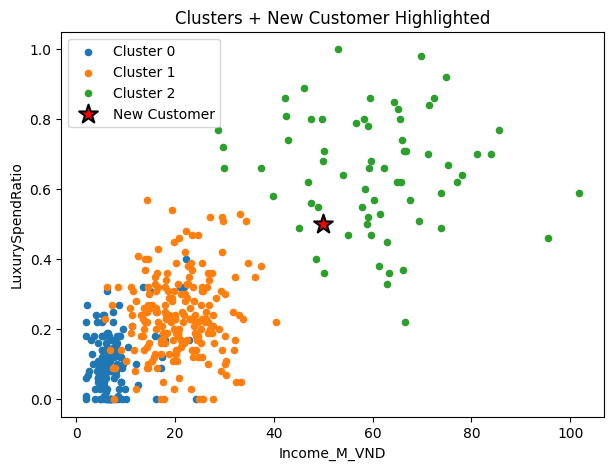

In [27]:
import matplotlib.pyplot as plt

ax_x, ax_y = "Income_M_VND", "LuxurySpendRatio"

plt.figure(figsize=(7,5))

# --- Vẽ 3 cụm hiện tại ---
for c in sorted(df["Cluster"].unique()):
    sub = df[df["Cluster"] == c]
    plt.scatter(
        sub[ax_x],
        sub[ax_y],
        s=20,
        label=f"Cluster {c}"
    )

# --- Vẽ khách hàng mới với màu khác ---
plt.scatter(
    new_cust[ax_x],
    new_cust[ax_y],
    c="red",        # màu nổi bật
    s=200,          # kích thước lớn hơn
    marker="*",     # dấu sao để dễ nhìn
    edgecolors="black",
    linewidths=1.5,
    label="New Customer"
)

plt.xlabel(ax_x)
plt.ylabel(ax_y)
plt.title("Clusters + New Customer Highlighted")
plt.legend()
plt.show()
